<a href="https://colab.research.google.com/github/ghubnerr/machine-learning/blob/main/flax_stuff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade -q git+https://github.com/deepmind/dm-haiku

  Preparing metadata (setup.py) ... done


In [ ]:
import jax
from jax import lax, random, numpy as jnp

import flax
from flax.core import freeze, unfreeze
from flax import linen as nn
from flax.training import train_state

import haiku as hk
import optax

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

import functools
from typing import Any, Callable, Sequence, Optional

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
model = nn.Dense(features=5) # nn.Linear in torch terms

# Similar to the Pytorch nn.Module class (from which all Flax NN layers inherit)
print(nn.Dense.__bases__)

(<class 'flax.linen.module.Module'>,)


## Init
Since we're handling state externally, we first initialize and then apply.

In [ ]:
seed = 23
key1, key2 = jax.random.split(jax.random.PRNGKey(seed))
x = jax.random.normal(key1, (10,))

y, params = model.init_with_output(key2, x)
# params = model.init(key2, x)

print(y)
# params = PyTree, and you're applying a function for every leaf
print(jax.tree.map(lambda x: x.shape, params))

# Automatic shape inference, immutable structure (FrozenDict)

[-1.2137773  -0.3663312   0.06677862 -2.0143986  -0.32107347]
{'params': {'bias': (5,), 'kernel': (10, 5)}}


In [ ]:
y = model.apply(params, x) # this is how you run inference in Flax, state is external
print(y)

# you can no longer do model(x)

[-1.2137773  -0.3663312   0.06677862 -2.0143986  -0.32107347]


## Apply

In [ ]:
# for contrast with haiku
model = hk.transform(lambda x: hk.Linear(5)(x))

seed = 23
key1, key2 = jax.random.split(jax.random.PRNGKey(seed))
x = jax.random.normal(key1, (10,))

params = model.init(key2, x)
y = model.apply(params, None, x)

print(y)

print(hk.Linear.__bases__)

[ 0.06356498  0.9046967   1.21922    -0.28187275 -1.2322015 ]
(<class 'haiku._src.module.Module'>,)


## Training a Linear Regression Model

In [ ]:
n_samples = 1500
x_dim = 2
y_dim = 1
noise_amplitude = 0.1

key, w_key, b_key = random.split(random.PRNGKey(seed), num=3)
W = random.normal(w_key, (x_dim, y_dim))
b = random.normal(b_key, (y_dim,))

true_params = freeze({'params': {'bias': b, 'kernel': W}})

# Generate samples with additional noise
key, x_key, noise_key = random.split(key, num=3)
xs = random.normal(x_key, (n_samples, x_dim))
ys = jnp.dot(xs, W) + b
ys += noise_amplitude * random.normal(noise_key, (n_samples, y_dim))
print(f'xs shape = {xs.shape}, ys shape = {ys.shape}')

xs shape = (1500, 2), ys shape = (1500, 1)


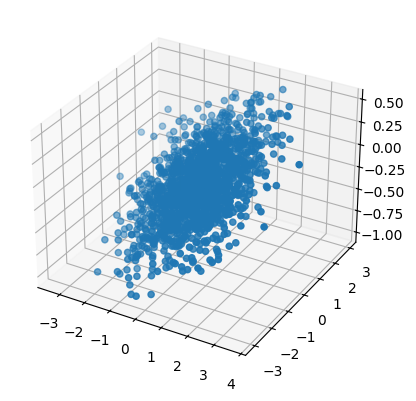

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
assert xs.shape[-1] == 2 and ys.shape[-1] == 1
ax.scatter(xs[:, 0], xs[:, 1], zs=ys)

# y = w*x + b: w1*x1 + w2*x2 + b -> 2D plane in 3D space

In [ ]:
def make_mse_loss(xs, ys):
    # Jitted version of the MSE loss

    def mse_loss(params):

        def squared_error(x, y):
            pred = model.apply(params, x)
            return jnp.inner(y-pred, y-pred) /2.0

        return jnp.mean(jax.vmap(squared_error)(xs, ys), axis=0)


    return jax.jit(mse_loss)

mse_loss = make_mse_loss(xs, ys)
value_and_grad_fn = jax.value_and_grad(mse_loss)


In [ ]:
from tqdm import tqdm

In [ ]:
model = nn.Dense(features=y_dim) # cheating but ok
params = model.init(key, xs)

lr = 0.3
epochs = 20
log_period_epoch = 5

for epoch in tqdm(range(epochs)):
    loss, grads = value_and_grad_fn(params)
    # We have two Pytrees, params and grads, and we traverse the leaves
    # Batch gradient descent
    params = jax.tree.map(lambda p, g: p - lr * g, params, grads)

    # Log every 'log_period_epoch' epochs
    if epoch % log_period_epoch == 0:
        print(f'Epoch {epoch}, loss = {loss}')



100%|██████████| 20/20 [00:00<00:00, 24.90it/s]

Epoch 0, loss = 0.6885043978691101
Epoch 5, loss = 0.020000522956252098
Epoch 10, loss = 0.005448050796985626
Epoch 15, loss = 0.0051234569400548935


## Optax SGD

Unlike Adam, which has in-memory state requirements, SGD is stateless

In [ ]:
opt_sgd = optax.sgd(learning_rate=lr)
opt_state = opt_sgd.init(params)
print(opt_state)

(EmptyState(), EmptyState())


In [ ]:
opt_adam = optax.adam(learning_rate=lr)
opt_state = opt_adam.init(params)
print(opt_state)

(ScaleByAdamState(count=Array(0, dtype=int32), mu={'params': {'bias': Array([0.], dtype=float32), 'kernel': Array([[0.],
       [0.]], dtype=float32)}}, nu={'params': {'bias': Array([0.], dtype=float32), 'kernel': Array([[0.],
       [0.]], dtype=float32)}}), EmptyState())


In [ ]:
params = model.init(key, xs)

for epoch in range(epochs):
    loss, grads = value_and_grad_fn(params)
    updates, opt_state = opt_sgd.update(grads, opt_state)
    params = optax.apply_updates(params, updates)


    if epoch % log_period_epoch == 0:
        print(f'Epoch {epoch}, loss = {loss}')

Epoch 0, loss = 0.6885043978691101
Epoch 5, loss = 0.020000522956252098
Epoch 10, loss = 0.005448050796985626
Epoch 15, loss = 0.0051234569400548935


## MLP in FLAX

In [ ]:
class MLP(nn.Module): # -> Python's @dataclass
    num_neurons_per_layer: Sequence[int]

    # def setup(self):
    #     self.layers = [nn.Dense(n) for n in self.num_neurons_per_layer]

    @nn.compact
    def __call__(self, x):
        activation = x
        for i, num_neurons in enumerate(self.num_neurons_per_layer):
            activation = nn.Dense(num_neurons)(activation)
            if i != len(self.num_neurons_per_layer) - 1:
                activation = nn.relu(activation)
        return activation

x_key, init_key = random.split(random.PRNGKey(seed))

model = MLP(num_neurons_per_layer=[16,8,1])
x = random.uniform(x_key, (4,4)) # dummy input
params = model.init(init_key, x)

y = model.apply(params, x)

print(jax.tree.map(jnp.shape, params))
print(f'Output: {y}')



{'params': {'Dense_0': {'bias': (16,), 'kernel': (4, 16)}, 'Dense_1': {'bias': (8,), 'kernel': (16, 8)}, 'Dense_2': {'bias': (1,), 'kernel': (8, 1)}}}
Output: [[-0.20487878]
 [ 0.0349005 ]
 [-0.19756585]
 [-0.32037985]]


## `param` in FLAX (trainable `variables`)

In [ ]:
class MyDenseImp(nn.Module):
    num_neurons: int
    weight_init: Callable = nn.initializers.lecun_normal()
    bias_init: Callable = nn.initializers.zeros # already a function, no ()

    @nn.compact
    def __call__(self, x):
        weight = self.param('weight',
                            self.weight_init, # RNG passed implicitly through init fn
                            (x.shape[-1], self.num_neurons))
        bias = self.param('bias', self.bias_init, (self.num_neurons,))
        return jnp.dot(x, weight) + bias

In [ ]:
x_key, init_key = random.split(random.PRNGKey(seed))

model = MyDenseImp(num_neurons=3)
x = random.uniform(x_key, (4,4))
params = model.init(init_key, x)

y = model.apply(params, x)

print(jax.tree.map(jnp.shape, params))
print(f'Output: {y}')

{'params': {'bias': (3,), 'weight': (4, 3)}}
Output: [[-0.45431203  0.14070599 -0.13996777]
 [-0.32604304 -0.02913585  0.21127702]
 [-0.16531762  0.26077443 -0.37982297]
 [-0.01778076  0.40737244 -0.10995434]]


In [ ]:
from inspect import signature

print(signature(nn.initializers.lecun_normal))
print(signature(nn.initializers.zeros))

(in_axis: 'int | Sequence[int]' = -2, out_axis: 'int | Sequence[int]' = -1, batch_axis: 'Sequence[int]' = (), dtype: 'DTypeLikeInexact' = <class 'jax.numpy.float64'>) -> 'Initializer'
(key: 'KeyArray', shape: 'core.Shape', dtype: 'DTypeLikeInexact' = <class 'jax.numpy.float64'>) -> 'Array'


## `variable` in FLAX (non-trainable ones)

note `variable` returns a reference, so you need `.value` to get it's value

In [ ]:
from pprint import pprint

In [ ]:
class BiasAdderWithRunningMean(nn.Module):
    decay: float = 0.99

    @nn.compact
    def __call__(self, x):
        is_initialized = self.has_variable('batch_stats', 'ema')

        # batch_stats is not an arbitrary name
        ema = self.variable('batch_stats', 'ema', lambda shape: jnp.zeros(shape), x.shape[1:])

        # defaults to params collection
        bias = self.param('bias', lambda key, shape: jnp.zeros(shape), x.shape[1:])

        if is_initialized:
            ema.value = self.decay * ema.value + (1.0 - self.decay) * jnp.mean(x, axis=0, keepdims=True)

        return x - ema.value + bias

x_key, init_key = random.split(random.PRNGKey(seed))

model = BiasAdderWithRunningMean()
x = random.uniform(x_key, (10,4))

variables = model.init(init_key, x)
print(f'Multiple collections = {variables}')

# We need to use mutable since regular params are not modified during the forward pass,
# but these variables are. We can't keep state internally so we have to return it
y, updated_non_trainable_params = model.apply(variables, x, mutable=['batch_stats'])
pprint(updated_non_trainable_params, indent=4)



Multiple collections = {'batch_stats': {'ema': Array([0., 0., 0., 0.], dtype=float32)}, 'params': {'bias': Array([0., 0., 0., 0.], dtype=float32)}}
{   'batch_stats': {   'ema': Array([[0.00421787, 0.00597094, 0.00638907, 0.00699901]], dtype=float32)}}


In [ ]:
def update_step(opt, apply_fn, x, opt_state, params, non_trainable_params):

    def loss_fn(params):
        y, updated_non_trainable_params = apply_fn(
            {'params': params, **non_trainable_params},
            x, mutable=list(non_trainable_params.keys())
        )

        loss = ((x - y) ** 2).sum()

        return loss, updated_non_trainable_params

    (loss, non_trainable_params), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

    return opt_state, params, non_trainable_params

model = BiasAdderWithRunningMean()
x = jnp.ones((10, 4))

variables = model.init(random.PRNGKey(seed), x)
params = variables.pop('params')
non_trainable_params = variables
del variables # avoid wasting resources

sgd_opt = optax.sgd(learning_rate=0.1)
opt_state = sgd_opt.init(params)

for _ in range(3):
    opt_state, params, non_trainable_params = update_step(sgd_opt, model.apply, x, opt_state, params, non_trainable_params)
    print(non_trainable_params)


{'batch_stats': {'ema': Array([[0.01, 0.01, 0.01, 0.01]], dtype=float32)}}
{'batch_stats': {'ema': Array([[0.0199, 0.0199, 0.0199, 0.0199]], dtype=float32)}}
{'batch_stats': {'ema': Array([[0.029701, 0.029701, 0.029701, 0.029701]], dtype=float32)}}


## Training State

In [ ]:
class DDNBlock(nn.Module):
    """
    Dense, dropout + batchnorm
    """
    num_neurons: int
    training: bool

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.num_neurons)(x)
        x = nn.Dropout(rate=0.5, deterministic=not self.training)(x)
        x = nn.BatchNorm(use_running_average=not self.training)(x)
        return x

key1, key2, key3, key4 = random.split(random.PRNGKey(seed), num=4)

model = DDNBlock(num_neurons=3, training=True)
x = random.uniform(key1, (3,4,4))

# Because of dropout we have to add its unique key
variables = model.init({'params': key2, 'dropout': key3}, x)
print(variables)

y, non_trainable_params = model.apply(variables, x, rngs={'dropout': key4}, mutable=['batch_stats'])

eval_model = DDNBlock(num_neurons=3, training=False)
# Because training=False we don't have stochasticity in the forward pass neither do we update the stats
y = eval_model.apply(variables, x)


{'params': {'Dense_0': {'kernel': Array([[-0.75637376,  0.01997767,  0.04605452],
       [ 0.65764475, -0.7379196 , -0.3011639 ],
       [ 0.806849  ,  0.7780827 ,  0.09813766],
       [ 0.15413891,  0.17243946,  0.44406676]], dtype=float32), 'bias': Array([0., 0., 0.], dtype=float32)}, 'BatchNorm_0': {'scale': Array([1., 1., 1.], dtype=float32), 'bias': Array([0., 0., 0.], dtype=float32)}}, 'batch_stats': {'BatchNorm_0': {'mean': Array([0., 0., 0.], dtype=float32), 'var': Array([1., 1., 1.], dtype=float32)}}}


# CNN on MNIST example in FLAX

In [ ]:
class CNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3,3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2,2), strides=(2,2))
        x = nn.Conv(features=64, kernel_size=(3,3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2,2), strides=(2,2))
        x = x.reshape((x.shape[0], -1)) # flatten
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        x = nn.log_softmax(x)
        return x

In [ ]:
import os

if not os.path.exists("./data"):
    os.mkdir("./data")
if not os.path.exists("./data/train"):
    os.mkdir("./data/train")
if not os.path.exists("./data/test"):
    os.mkdir("./data/test")

In [ ]:
def custom_transform(x):
    return np.expand_dims(np.array(x, dtype=np.float32), axis=2) / 255.

def custom_collate_fn(batch):
    transposed_data = list(zip(*batch))

    labels = np.array(transposed_data[1])
    imgs = np.stack(transposed_data[0])

    return imgs, labels

MNIST_IMG_SIZE = (28, 28, 1)
batch_size = 128

train_dataset = MNIST(root='./data/train', train=True, download=True, transform=custom_transform)
test_dataset = MNIST(root='./data/test', train=False, download=True, transform=custom_transform)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)


test_images = jnp.array(train_dataset.data)
train_labels = jnp.array(train_dataset.targets)

test_images = np.expand_dims(jnp.array(test_dataset.data), axis=3)
test_labels = jnp.array(test_dataset.targets)


7


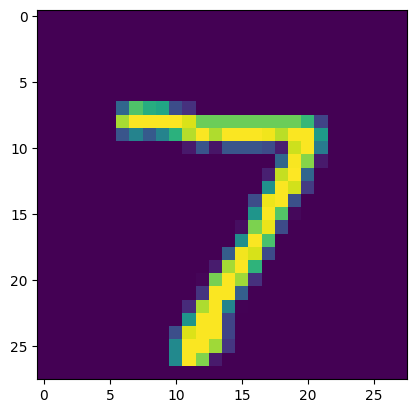

In [ ]:
imgs, labels = next(iter(test_loader))
img = imgs[0].reshape(MNIST_IMG_SIZE)[:, :, 0]

gt_label = labels[0]
print(gt_label)
plt.imshow(img) ; plt.show()

### Training Loop

In [ ]:
@jax.jit
def train_step(state, imgs, gt_labels):
    def loss_fn(params):
        logits = CNN().apply({'params': params}, imgs)
        one_hot_gt_labels = jax.nn.one_hot(gt_labels, num_classes=10)
        loss = -jnp.mean(jnp.sum(one_hot_gt_labels * logits, axis=-1))
        return loss, logits

    (_, logits), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads) # concise update
    metrics = compute_metrics(logits=logits, gt_labels=gt_labels)

    return state, metrics

@jax.jit
def eval_step(state, imgs, gt_labels):
    logits = CNN().apply({'params': state.params}, imgs)
    return compute_metrics(logits=logits, gt_labels=gt_labels)


In [ ]:
def train_one_epoch(state, dataloader, epoch):
    batch_metrics = []
    for cnt, (imgs, labels) in enumerate(dataloader):
        state, metrics = train_step(state, imgs, labels)
        batch_metrics.append(metrics)

    batch_metrics_np = jax.device_get(batch_metrics)
    epoch_metrics_np = {
        k: np.mean([metrics[k] for metrics in batch_metrics_np])
        for k in batch_metrics_np[0]
    }

    return state, epoch_metrics_np

def evaluate_model(state, test_imgs, test_labels):
    metrics = eval_step(state, test_imgs, test_labels)
    metrics = jax.device_get(metrics)  # pull from the accelerator onto host (CPU)
    metrics = jax.tree.map(lambda x: x.item(), metrics)  # np.ndarray -> scalar
    return metrics

In [ ]:
def create_train_state(key, learning_rate, momentum):
    cnn = CNN()
    params = cnn.init(key, jnp.ones([1, *MNIST_IMG_SIZE]))['params']
    sgd_opt = optax.sgd(learning_rate, momentum)
    # TrainState is a simple built-in wrapper class that makes things a bit cleaner
    return train_state.TrainState.create(apply_fn=cnn.apply, params=params, tx=sgd_opt)

def compute_metrics(*, logits, gt_labels):
    one_hot_gt_labels = jax.nn.one_hot(gt_labels, num_classes=10)

    loss = -jnp.mean(jnp.sum(one_hot_gt_labels * logits, axis=-1))
    accuracy = jnp.mean(jnp.argmax(logits, -1) == gt_labels)

    metrics = {
        'loss': loss,
        'accuracy': accuracy,
    }
    return metrics

In [ ]:
seed = 0
learning_rate = 0.1
momentum = 0.9
num_epochs = 10
batch_size = 32

train_state = create_train_state(jax.random.PRNGKey(seed), learning_rate, momentum)

for epoch in range(1, num_epochs + 1):
    train_state, train_metrics = train_one_epoch(train_state, train_loader, epoch)
    print(f'Epoch {epoch}, train metrics: {train_metrics}')
    test_metrics = evaluate_model(train_state, test_images, test_labels)
    print(f'Epoch {epoch}, accuracy: {test_metrics["accuracy"]}')


Epoch 1, train metrics: {'accuracy': 0.9337774, 'loss': 0.22099407}
Epoch 1, accuracy: 0.9791999459266663
Epoch 2, train metrics: {'accuracy': 0.98355705, 'loss': 0.05210821}
Epoch 2, accuracy: 0.9871999621391296
Epoch 3, train metrics: {'accuracy': 0.98939973, 'loss': 0.033375353}
Epoch 3, accuracy: 0.9871999621391296
Epoch 4, train metrics: {'accuracy': 0.99235445, 'loss': 0.02537614}
Epoch 4, accuracy: 0.9871999621391296
Epoch 5, train metrics: {'accuracy': 0.9939737, 'loss': 0.01973854}
Epoch 5, accuracy: 0.9870999455451965
Epoch 6, train metrics: {'accuracy': 0.994558, 'loss': 0.016317535}
Epoch 6, accuracy: 0.9902999997138977
Epoch 7, train metrics: {'accuracy': 0.9956764, 'loss': 0.014045925}
Epoch 7, accuracy: 0.9842000007629395
Epoch 8, train metrics: {'accuracy': 0.9970119, 'loss': 0.0096833175}
Epoch 8, accuracy: 0.9882999658584595
Epoch 9, train metrics: {'accuracy': 0.9976796, 'loss': 0.007891604}
Epoch 9, accuracy: 0.9914000034332275
Epoch 10, train metrics: {'accuracy': 